In [1]:
import qiskit
from qiskit import QuantumCircuit

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

import time
import numpy as np

import matplotlib.pyplot as plt

# Use ZNE to simulate quantum many body scars with Qiskit on IBMQ backends

This tutorial shows how to error mitigate a quantum simulation using ZNE, and is applied to a case where the dynamics show signs of quantum many body scars. The example is based on the model studied in https://arxiv.org/abs/2203.08291. That is, the Hamiltonian that is studied can be written in terms of Pauli matrices as follows
\begin{equation}
H = H_{ZZ} + H_Z + H_X,
\end{equation}
\begin{equation}
H = V\sum_{i=1}^{L-1}Z_iZ_{i+1} - 2V \sum_{i=2}^{L-1}Z_i - V(Z_1 + Z_L) + \Omega\sum_{i=1}^L X_i.
\end{equation}
This is an Ising model with an Ising interaction strength $V$, with longitudinal field with strength proportional to $V$ and transverse field with strength proportional to $\Omega$. Note that this Ising chain is defined with open boundary conditions, i.e. the strength of the field at the boundaries ($i = 1$ and $i = L$) is a factor 2 smaller than at the other sites of the chain. More information on the model can be found in the article.

The dynamics of this model is governed by the Schrödinger equation
\begin{equation}
\frac{d}{dt}\vert\Psi(t)\rangle = -i H\vert\Psi(t)\rangle,
\end{equation}
which can formally be solved as 
\begin{equation}
\vert\Psi(t + \Delta t)\rangle = e^{-i H\Delta t}\vert\Psi(t)\rangle = U(\Delta t)\vert\Psi(t)\rangle.
\end{equation}
To simulate the dynamics using a gate sequence one performs a Trotter decomposition of this unitary operator, that is
\begin{equation}
U(\Delta t) \approx e^{-iH_{ZZ}\Delta t}e^{-iH_{Z}\Delta t}e^{-iH_{X}\Delta t},
\end{equation}
which is a product of different unitary operators. Finally, one can express each of these unitary operators as a gate sequence of single-qubit gates or two-qubit gates that are subsequently applied.

The resulting gate sequence is defined in the following function

In [2]:
def trotter_evolution_H(L: int, V: float,
                        Omega: float, dt: float) -> qiskit.QuantumCircuit:
    '''Return the circuit that performs a time step.
    
    Args:
        L: Length of the Ising chain
        V: Ising interaction strength
        Omega: Transverse field strength
        dt: Time step of unitary evolution
    '''
    
    cq = qiskit.QuantumCircuit(L)        
    
    # Apply Rx gates:
    for ii in range(L):
        cq.rx(2*Omega*dt, ii)
        
        
    # Apply Rz gates:
    cq.rz(-2*V*dt, 0)
    for ii in range(1, L-1):
        cq.rz(-4*V*dt, ii)
    cq.rz(-2*V*dt, L-1)
    
    
    # Mitiq ZNE raises an error for the usage of rzz.
    # We will give an explicit implementation of the 
    # 2-CNOT implementation of the Rzz gate:
    for ii in range(1, L-1, 2):
        cq.cnot(ii, ii+1)
        cq.rz(2*V*dt, ii + 1)
        cq.cnot(ii, ii+1)

    for ii in range(0, L-1, 2):
        cq.cnot(ii, ii+1)
        cq.rz(2*V*dt, ii + 1)
        cq.cnot(ii, ii+1)
        

    return cq

By subsequently applying this unitary operator (or its circuit equivalent), one (approximately) time evolves according to the system Hamiltonian.

In this example we will limit ourselves to calculating the behaviour of the staggered magnetization in the $z$-direction. This is defined as 
\begin{equation}
Z_\pi = \sum_{i=1}^{L}(-1)^i Z_i.
\end{equation}
The following function calculates the staggered z-magnetization for a given set of raw measurement counts

In [3]:
def staggered_mz(L: int, counts: qiskit.result.counts.Counts) -> float:
    '''Calculate the staggered z-magnetization
    
    Args:
    L: Length of the Ising chain
    counts: raw measurement counts
    '''
    
    sz = 0
    ncounts = 0
    
    # We use (L-1)-ii since the state strings start with
    # the last qubit and end with the first qubit.
    stag = (-1)**(1 + np.array([(L-1)-ii for ii in range(L)]))
    
    for state, state_count in counts.items():
        bit_array = np.array([-2*int(i)+1 for i in state])
        ncounts += state_count
        
        sz += state_count*np.sum(stag*bit_array)
        
        
    return sz/(ncounts*L)

For this tutorial we will not use real (quantum) hardware. If you do wish to do so, you can change the backends below to your desired backend. 

Note: Using an IBM quantum computer requires a valid IBMQ account. See https://quantum-computing.ibm.com/ for instructions to create an account, save credentials, and see online quantum computers.

In [4]:
USE_REAL_HARDWARE = False

In [5]:
#from qiskit_ibm_provider import IBMProvider
#
#if USE_REAL_HARDWARE:
#    provider = IBMProvider(token="MY_IBM_QUANTUM_TOKEN")   # Get the API token in https://quantum-computing.ibm.com/account
#    backend = provider.get_backend("ibmq_qasm_simulator")  # Set quantum computer here!
#else:
#    backend = qiskit.Aer.get_backend("qasm_simulator")     # Default to a simulator.

In [6]:
backend = qiskit.Aer.get_backend("qasm_simulator")     # Default to a simulator.

We set up an executor that simulates the desired circuit a certain amount of shots and returns the measurement statistics of our desired expectation value in the following function

In [7]:
def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 32768) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    if NO_NOISE:
        # Simulate the circuit without noise
        job = qiskit.execute(
            experiments=circuit,
            backend=qiskit.Aer.get_backend("qasm_simulator"),
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
            )
    else:
        if USE_REAL_HARDWARE:
            # Run the circuit on hardware
            job = qiskit.execute(
                experiments=circuit,
                backend=backend,
                optimization_level=0,  # Important to preserve folded gates.
                shots=shots
            )
        else:
            # Simulate the circuit with noise
            noise_model = initialized_depolarizing_noise(noise_level=0.02)
            job = qiskit.execute(
                experiments=circuit,
                backend=backend,
                noise_model=noise_model,
                basis_gates=noise_model.basis_gates,
                optimization_level=0,  # Important to preserve folded gates.
                shots=shots,
            )

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    expectation_value = staggered_mz(L, counts)
    
    
    return expectation_value


We now have all necessary components to perform a time evolution of the Ising Hamiltonian. The Hamiltonian parameters used in the following are those used in the article to create Fig. 3 and 4 (https://arxiv.org/abs/2203.08291). However, in the following we will stick to a smaller Ising chain with 6 sites for the sake of simplicity. 

As an initial test we will time evolve the system over one time step $dt$ (you can change this by enlarging the parameter $n_{dt}$). The system is initialized in the Néel state, that is the $\vert 010101\rangle$ state. We simulate results with noise, and calculate the unmitigated and mitigated result. Additionally, we also calculate the result in case no noise is present in the system, that is, an ideal Trotted decomposed time evolution.

In [8]:
# System parameters
L = 6
V = 1
Omega = 0.24
dt = 1
n_dt = 1 #number of time steps

In [9]:
# Initialise quantum circuit
circuit = qiskit.QuantumCircuit(L) 

# Initialise time step quantum circuit
cc = trotter_evolution_H(L, V, Omega, dt)

# Initialise the Néel state |010101...>
for ii in range(1,L,2):
    circuit.x(ii)

# Time evolve n_dt time steps
for _ in range(n_dt):
    circuit = circuit.compose(cc)

# Measure in computational basis
circuit.measure_all() 

In [10]:
NO_NOISE = False

In [11]:
t1 = time.time()
unmitigated = ibmq_executor(circuit)
t2 = time.time()
print(f"Unmitigated result {unmitigated:.3f}, after {t2-t1:.4f}s.")

Unmitigated result -0.804, after 0.2778s.


In [12]:
t1 = time.time()
mitigated = zne.execute_with_zne(circuit, ibmq_executor)
t2 = time.time()
print(f"Mitigated result {mitigated:.3f}, after {t2-t1:.4f}s.")

Mitigated result -0.888, after 0.4032s.


In [13]:
NO_NOISE = True
t1 = time.time()
unmitigated = ibmq_executor(circuit)
t2 = time.time()
print(f"No noise result {unmitigated:.3f}, after {t2-t1:.4f}s.")

No noise result -0.887, after 0.0733s.


# Create a time evolution plot up to a certain time

Finally, we will simulate the time evolution of the system up to various times to create a figure of the behaviour of the staggered $z$-magnetization throughout time. The system is initialized in the Néel state and we time evolve for a maximum of $n_{dt} = 40$ steps.

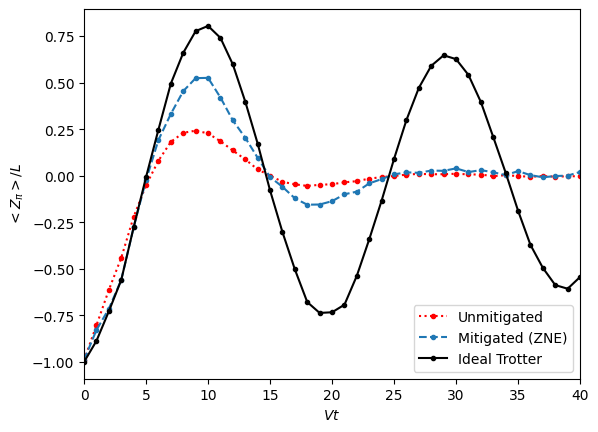

In [14]:
# System parameters
L = 6
V = 1
Omega = 0.24
dt = 1
n_dt = 40


unmitigated_list = []
mitigated_list = []
nonoise_list = []

# Results for t = 0:
# Initialise quantum circuit
circuit = qiskit.QuantumCircuit(L) 

# Initialise the Néel state |010101...>
for ii in range(1,L,2):
    circuit.x(ii)

# Measure in computational basis
circuit.measure_all() 

# Run circuit on the backends
NO_NOISE = False
unmitigated = ibmq_executor(circuit)
mitigated = zne.execute_with_zne(circuit, ibmq_executor)

NO_NOISE = True
nonoise = ibmq_executor(circuit)


# Store results
unmitigated_list.append(unmitigated)
mitigated_list.append(mitigated)
nonoise_list.append(nonoise)


# Results for t > 0:
for ndt in range(1, n_dt + 1):
    # Initialise quantum circuit
    circuit = qiskit.QuantumCircuit(L) 

    # Initialise time step quantum circuit
    cc = trotter_evolution_H(L, V, Omega, dt)

    # Initialise the Néel state |010101...>
    for ii in range(1,L,2):
        circuit.x(ii)

    # Time evolve n_dt time steps
    for _ in range(ndt):
        circuit = circuit.compose(cc)

    # Measure in computational basis
    circuit.measure_all() 
    
    # Run circuit on the backends
    NO_NOISE = False
    unmitigated = ibmq_executor(circuit)
    mitigated = zne.execute_with_zne(circuit, ibmq_executor)

    NO_NOISE = True
    nonoise = ibmq_executor(circuit)
    
    
    # Store results    
    unmitigated_list.append(unmitigated)
    mitigated_list.append(mitigated)
    nonoise_list.append(nonoise)
    
    
# Creation of the figure
time_list = np.arange(0, n_dt + 1, 1)

plt.figure()
plt.plot(time_list, unmitigated_list,marker =".", c="r", linestyle =":", label = "Unmitigated")
plt.plot(time_list, mitigated_list, marker = ".", linestyle ="--", label = "Mitigated (ZNE)")
plt.plot(time_list, nonoise_list, marker = '.', c="k", label = "Ideal Trotter")

plt.xlim([time_list[0], time_list[-1]])
plt.xlabel(r"$Vt$")
plt.ylabel(r"$<Z_\pi>/L$")
plt.legend()
plt.show()